To summarize the case, given dataset has excessive number of zero-valued observations. Problem can be divited into two seperete problems:
1. one that determines whether an event occurs (claim is made)
2. other determines frequency of events when they do occur

Two possible GLM models that can be taken into considerations in this case are:
1. Zero-Inflated Poisson: Assumes that excess zeros come from a separate process, while the remaining data follow a Poisson distribution.
2. Negative Binomial: Extends Poisson by accounting for overdispersion (greater variance than in the Poisson model).

We already proven in the data exploration notebook that variance of claim frequency is aproximatelly 2 times bigger than its mean, therefore I will use Likelihood Ratio Test to compare these models.


### Import libraries and data load

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import NegativeBinomial
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from scipy.stats import chi2
import pickle

In [ ]:
# load data
df = pd.read_csv("feature_selected_data.csv")
df

,VehPower,VehAge,DrivAge,Area,VehBrand,VehGas,Region,ClaimFrequency,VehPowerDriverAge,TransformBonusMalus,TransformDensity,isClaim
0,5.0,0.0,55.0,D,B12,Regular,R82,1.000000,0.090909,3.912023,7.104144,1
1,5.0,0.0,55.0,D,B12,Regular,R82,1.298701,0.090909,3.912023,7.104144,1
2,6.0,2.0,52.0,B,B12,Diesel,R22,1.333333,0.115385,3.912023,3.988984,1
3,7.0,0.0,46.0,B,B12,Diesel,R72,1.190476,0.152174,3.912023,4.330733,1
4,6.0,2.0,38.0,E,B12,Regular,R31,1.923077,0.157895,3.912023,8.007367,1
...,...,...,...,...,...,...,...,...,...,...,...,...
677997,4.0,0.0,54.0,E,B12,Regular,R93,0.000000,0.074074,3.912023,8.106816,0
677998,4.0,0.0,41.0,E,B12,Regular,R11,0.000000,0.097561,4.553877,9.195227,0
677999,6.0,2.0,45.0,D,B12,Diesel,R82,0.000000,0.133333,3.912023,7.187657,0
678000,4.0,0.0,60.0,B,B12,Regular,R26,0.000000,0.066667,3.912023,4.553877,0


### Preprocess data for model training

In [ ]:
# Prepare training and testing dataset
X = df.drop(columns=['ClaimFrequency', "isClaim"], axis=1)
y = df['ClaimFrequency']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# spliting features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

In [ ]:
# creating preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop="first"), cat_features) # droping first categorical variable to avoid colinearity (Area_A, Region_R11, VehBrand_B1, VehGas_Diesel)
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed = pd.DataFrame(X_train_transformed.toarray(), columns=preprocessor.get_feature_names_out())
X_test_transformed = pd.DataFrame(X_test_transformed.toarray(), columns=preprocessor.get_feature_names_out())

with open('preprocessor_glm.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:
# reseting index
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True) 

In [ ]:
# calculating variance inflation factor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_transformed.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_transformed.values, i) for i in range(X_train_transformed.shape[1])]

print(vif_data[vif_data["VIF"] > 10])

                  Feature        VIF
3  num__VehPowerDriverAge  10.301801


Calculating variance inflation factor, shows that feature num__VehPowerDriverAge is highly corelated with other features and makes risk of collinearity in the model higher. Therefore I will not use this feature in building model

In [ ]:
# calculating overdispersion ratio
mean_y = y_train.mean()
var_y = y_train.var()
dispersion_ratio = var_y / mean_y
print(f"Overdispersion ratio: {dispersion_ratio:.2f}")

Overdispersion ratio: 1.92


In [ ]:
# droping num__VehPowerDriverAge
X_train_transformed.drop(columns=["num__VehPowerDriverAge"], axis=1, inplace=True)
X_test_transformed.drop(columns=["num__VehPowerDriverAge"], axis=1, inplace=True)

### Likelihood Ratio Test

In [ ]:
# Fit Zero-Inflated Poisson Model
zip_model = ZeroInflatedPoisson(y_train, sm.add_constant(X_train_transformed), exog_infl=sm.add_constant(X_train_transformed)).fit(maxiter=1000)
print(zip_model.summary())

Optimization terminated successfully.
         Current function value: 0.246245
         Iterations: 306
         Function evaluations: 309
         Gradient evaluations: 309
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:          ClaimFrequency   No. Observations:               542401
Model:             ZeroInflatedPoisson   Df Residuals:                   542358
Method:                            MLE   Df Model:                           42
Date:                 Thu, 13 Mar 2025   Pseudo R-squ.:                 0.01557
Time:                         18:45:04   Log-Likelihood:            -1.3356e+05
converged:                        True   LL-Null:                   -1.3568e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------

In [ ]:
# Fit Negative Binomial
nb_model = NegativeBinomial(y_train, sm.add_constant(X_train_transformed)).fit(maxiter=1000)
print(nb_model.summary())

Optimization terminated successfully.
         Current function value: 0.248662
         Iterations: 61
         Function evaluations: 76
         Gradient evaluations: 76
                     NegativeBinomial Regression Results                      
Dep. Variable:         ClaimFrequency   No. Observations:               542401
Model:               NegativeBinomial   Df Residuals:                   542358
Method:                           MLE   Df Model:                           42
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                0.008441
Time:                        18:52:41   Log-Likelihood:            -1.3487e+05
converged:                       True   LL-Null:                   -1.3602e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const     

In [19]:
# Likelihood Ratio Test to compare models
lr_stat = 2 * (zip_model.llf - nb_model.llf)
df_diff = len(zip_model.params) - len(nb_model.params) 
p_value = chi2.sf(lr_stat, df_diff)
print(f"Likelihood Ratio Test Statistic: {lr_stat}, p-value: {p_value}")

best_model = zip_model if p_value < 0.05 else nb_model
print("Selected Model:", "ZIP" if p_value < 0.05 else "NB")

with open('glm_model_all.pkl','wb') as f:
    pickle.dump(best_model,f)

Likelihood Ratio Test Statistic: 2621.8753257423523, p-value: 0.0
Selected Model: ZIP


Likelihood Ratio Test proves that more complicated model, in this case Zero-Inflated Poisson, brings significant improvment in model fitting.

### Feature selection and model training

In [8]:
# Backward Stepwise Feature Selection
def backward_stepwise_selection(model, X, X_infl, y, threshold=0.05):
    """
    Perform backward stepwise selection for a Zero-Inflated Poisson model.
    
    Parameters:
    - model: Fitted ZeroInflatedPoisson model.
    - X: DataFrame for the Poisson regression part.
    - X_infl: DataFrame for the zero-inflation part.
    - y: Target variable.
    - threshold: p-value threshold for feature removal.
    """
    model_class = model.model.__class__
    
    while True:
        p_values = model.pvalues.drop('const', errors='ignore') 
        worst_feature = p_values.idxmax()
        
        print(f"Worst feature: {worst_feature}, p_value: {p_values.max()}")
        
        if p_values.max() > threshold:
            if worst_feature.startswith("inflate_"):
                original_feature = worst_feature.replace("inflate_", "", 1)
                if original_feature in X_infl.columns:
                    X_infl = X_infl.drop(columns=[original_feature])
            else:
                if worst_feature in X.columns:
                    X = X.drop(columns=[worst_feature])
            
            model = model_class(y, sm.add_constant(X), exog_infl=sm.add_constant(X_infl), inflation='logit').fit(maxiter=200)
        else:
            break
    
    return model, X, X_infl

In [ ]:
# backward stepwise selection for zero inflated poisson model
with open('glm_model_all.pkl', 'rb') as f:
    best_model = pickle.load(f)

final_model, final_X_train, final_X_train_infl = backward_stepwise_selection(best_model, X_train_transformed, X_train_transformed, y_train)

with open('glm_model.pkl','wb') as f:
    pickle.dump(final_model,f)

### Model evaluation

In [7]:
# model summary
with open('glm_model.pkl', 'rb') as f:
    final_model = pickle.load(f)

print(final_model.summary())

                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:          ClaimFrequency   No. Observations:               542401
Model:             ZeroInflatedPoisson   Df Residuals:                   542380
Method:                            MLE   Df Model:                           20
Date:                 Fri, 14 Mar 2025   Pseudo R-squ.:                 0.01541
Time:                         12:07:42   Log-Likelihood:            -1.3359e+05
converged:                        True   LL-Null:                   -1.3568e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
inflate_const                        2.4961      0.021    116.178      0.000       2.454       2.538
inflate_num__VehAge                  0.2089      0.008   

In [ ]:
glm_columns = final_model.model.exog_names
col_names_X = [x for x in glm_columns if not x.startswith("inflate_") and x != 'const']
col_names_X_infl = [x.replace("inflate_", "") for x in glm_columns if x.startswith("inflate_") and x != 'inflate_const']

In [53]:
y_pred.describe()

count    135601.000000
mean          0.077109
std           0.028221
min           0.020067
25%           0.058209
50%           0.071269
75%           0.088724
max           0.407276
dtype: float64

In [55]:
y_test.describe()

count    135601.000000
mean          0.073587
std           0.375345
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.151515
Name: ClaimFrequency, dtype: float64

Comparison of prediction and labels in test sets shows, that model isn't very good in predicting zeros even with usage of zero-inflation mechanism.

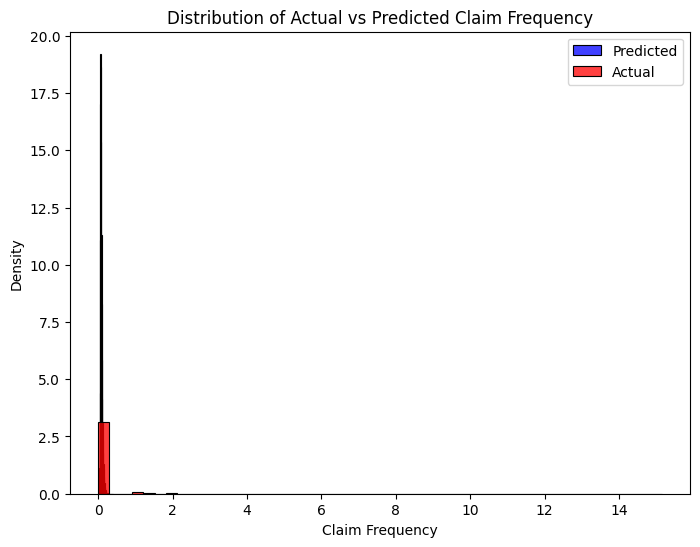

In [39]:
# grafical presentation of model results
final_X_test = X_test_transformed[col_names_X]
final_X_test_infl = X_test_transformed[col_names_X_infl]
y_pred = final_model.predict(exog=sm.add_constant(final_X_test), exog_infl=sm.add_constant(final_X_test_infl)) 

plt.figure(figsize=(8, 6))
sns.histplot(y_pred, bins=50, color='blue', label='Predicted', stat="density")
sns.histplot(y_test, bins=50, color='red', label='Actual', stat="density")
plt.xlabel("Claim Frequency")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Actual vs Predicted Claim Frequency")
plt.show()

In [41]:
# calculating predictions for train set
final_X_train = X_train_transformed[col_names_X]
final_X_train_infl = X_train_transformed[col_names_X_infl]
y_pred_train = final_model.predict(exog=sm.add_constant(final_X_train), exog_infl=sm.add_constant(final_X_train_infl))

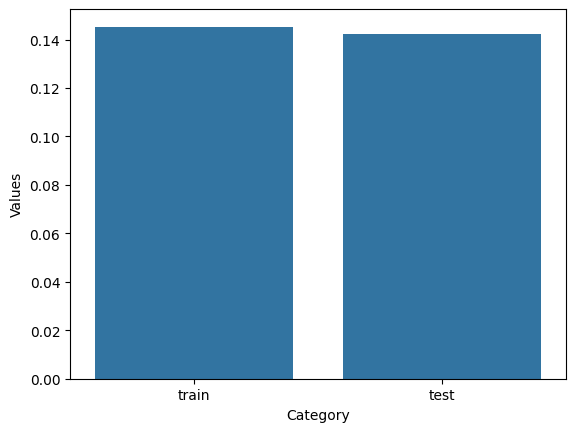

MAE train:  0.1452785684288314
MAE test:  0.14227349987841423


In [43]:
# evaluation of overfitting
MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test = mean_absolute_error(y_test, y_pred)

data = pd.DataFrame({
    'Category': ['train', 'test'],
    'Values': [MAE_train, MAE_test]
})

# Create the bar plot
sns.barplot(x='Category', y='Values', data=data)

# Show the plot
plt.show()
print("MAE train: ", MAE_train)
print("MAE test: ", MAE_test)

Quite unexpectedly, mean squared error is higher for test set than training set. For sure overfitting isn't a problem in this case. Ensuring similar structure of claim frequency in both train and test sets, for example by stratified splitting method might resolve the problem.

### Aditional Reaserch

#### largest and lowest claim frequency prediction

In [47]:
# top 10 observations with higher claim frequency
top_10 = df.nlargest(n=10, columns=["ClaimFrequency"])
top_10

,VehPower,VehAge,DrivAge,Area,VehBrand,VehGas,Region,ClaimFrequency,VehPowerDriverAge,TransformBonusMalus,TransformDensity,isClaim
304474,4.0,12.0,52.0,D,B1,Regular,R91,15.151515,0.076923,3.912023,6.714171,1
321238,4.0,12.0,52.0,D,B1,Regular,R91,15.151515,0.076923,3.912023,6.714171,1
364427,5.0,9.0,23.0,E,B3,Diesel,R11,14.814815,0.217391,4.499810,8.842749,1
320754,4.0,12.0,52.0,D,B1,Regular,R91,12.195122,0.076923,3.912023,6.714171,1
342114,5.0,7.0,40.0,C,B2,Diesel,R91,11.111111,0.125000,3.931826,5.998937,1
522546,4.0,1.0,71.0,A,B12,Regular,R52,10.000000,0.056338,3.912023,3.737670,1
214596,4.0,10.0,24.0,D,B1,Regular,R94,9.375000,0.166667,4.499810,7.578145,1
203389,4.0,2.0,57.0,D,B4,Regular,R82,8.333333,0.070175,3.912023,7.104144,1
424350,6.0,12.0,56.0,E,B1,Diesel,R82,8.333333,0.107143,4.615121,9.138522,1
461804,4.0,7.0,31.0,D,B2,Diesel,R54,8.333333,0.129032,4.219508,7.587817,1


In [ ]:
# transformying input and making predictions
top_10_transformed = pd.DataFrame(preprocessor.transform(top_10).toarray(), columns=preprocessor.get_feature_names_out())
final_model.predict(exog=sm.add_constant(top_10_transformed[col_names_X]), exog_infl=sm.add_constant(top_10_transformed[col_names_X_infl]))

0    0.047506
1    0.047506
2    0.102723
3    0.047506
4    0.042753
5    0.089862
6    0.111204
7    0.092502
8    0.167211
9    0.079642
dtype: float64

In [50]:
# 10 observations with lowest claim frequency
bottom_10 = df.nsmallest(n=10, columns=["ClaimFrequency"])
bottom_10

,VehPower,VehAge,DrivAge,Area,VehBrand,VehGas,Region,ClaimFrequency,VehPowerDriverAge,TransformBonusMalus,TransformDensity,isClaim
9385,6.0,15.0,50.0,A,B2,Diesel,R24,0.0,0.120000,3.912023,3.367296,0
9386,6.0,15.0,50.0,A,B2,Diesel,R24,0.0,0.120000,3.912023,3.367296,0
9387,6.0,8.0,30.0,A,B1,Diesel,R53,0.0,0.200000,4.219508,3.871201,0
9388,6.0,8.0,30.0,A,B1,Diesel,R53,0.0,0.200000,4.043051,3.871201,0
9389,7.0,4.0,44.0,B,B14,Diesel,R24,0.0,0.159091,3.912023,4.025352,0
9390,6.0,10.0,49.0,A,B3,Diesel,R24,0.0,0.122449,4.553877,3.258097,0
9391,6.0,4.0,33.0,A,B1,Diesel,R24,0.0,0.181818,3.912023,2.772589,0
9392,7.0,8.0,31.0,A,B5,Diesel,R24,0.0,0.225806,3.912023,2.833213,0
9393,7.0,12.0,46.0,C,B5,Diesel,R24,0.0,0.152174,3.912023,4.836282,0
9394,6.0,11.0,55.0,B,B1,Diesel,R24,0.0,0.109091,3.912023,4.204693,0


In [51]:
# transformying input and making predictions
bottom_10_transformed = pd.DataFrame(preprocessor.transform(bottom_10).toarray(), columns=preprocessor.get_feature_names_out())
final_model.predict(exog=sm.add_constant(bottom_10_transformed[col_names_X]), exog_infl=sm.add_constant(bottom_10_transformed[col_names_X_infl]))

0    0.050133
1    0.050133
2    0.079624
3    0.062471
4    0.065780
5    0.136230
6    0.056763
7    0.054351
8    0.059531
9    0.060730
dtype: float64

Explorying top 10 and bottom 10 claim frequency variables shows that model can't handle extreme values properly.